The purpose of this file is classify the galaxies in the large scale hydrodynamic cosmological simulation IllustrisTNG100-1 based on the morphological parameters. After classification, I am going to play around with supervised machine learning algorithms by using 'non-morphological features'. This is done in another file... Here, I just want to visualize the data.

In [1]:
import h5py
import numpy as np
import time
import pandas as pd
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#start_time = time.time()


#for value in f.values():
#    print(value)
#for key in f.keys():
#    print(key)

Load the morphological parameters from an hdf5 file.

In [2]:
f = h5py.File('/Users/spencershortt/TNG2019/morphs_g.hdf5','r+')
#print(list(f["flag"]))

subfind_id=np.array(f["subfind_id"])
flag=np.array(f["flag"])
flag_sersic=np.array(f["flag_sersic"])
concentration=np.array(f["concentration"])
gini=np.array(f["gini"])
m20=np.array(f["m20"])
gini_m20_bulge=np.array(f["gini_m20_bulge"])
gini_m20_merger=np.array(f["gini_m20_merger"])
r20=np.array(f["r20"])
sersic_n=np.array(f["sersic_n"])

In [3]:
df=pd.DataFrame([subfind_id,gini, m20, concentration, flag] ).transpose()
df.columns=['id','gini',"m20","concentration","flag"]
df["label"]=""
df.tail()



,id,gini,m20,concentration,flag,label
12530,704187.0,0.517132,-1.793419,2.897814,0.0,
12531,719337.0,0.544473,-1.996610,3.281157,0.0,
12532,727485.0,0.539991,-1.821634,2.973282,0.0,
12533,738596.0,0.569533,-1.894974,3.072260,0.0,
12534,752194.0,0.543225,-1.888321,2.986496,0.0,


Label the galaxies based on a subset of the morphological parameters. Details can be found in https://arxiv.org/pdf/1809.08239.pdf SECTION 4.4.3

In [4]:
flag_condition=df.flag.values==0
merger_line_condition=df.gini.values>-.14*df.m20.values + .33
early_type_condition=(df.gini.values>.14*df.m20.values+.80 ) & ~merger_line_condition
late_type_condition= ~merger_line_condition & ~early_type_condition 

df["label"]=df["label"].where(~(merger_line_condition & flag_condition),0)#Merger
df["label"]=df["label"].where(~(early_type_condition & flag_condition),1)#Elliptical
df["label"]=df["label"].where(~(late_type_condition & flag_condition),2) #Spiral

df=df.drop(df[df["flag"]==1].index)



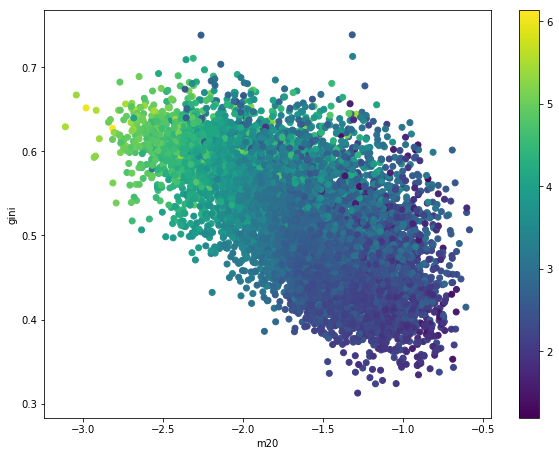

In [5]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
scatter=axes.scatter(df["m20"],df["gini"], c=df["concentration"])
axes.set_xlabel("m20")
axes.set_ylabel("gini")
axes.invert_xaxis
fig.colorbar(scatter, ax=axes)


In [6]:
df.head()

,id,gini,m20,concentration,flag,label
0,0.0,0.614704,-2.752232,4.527077,0.0,1
1,1.0,0.574363,-2.220317,3.663501,0.0,1
2,2.0,0.647357,-2.288265,4.597688,0.0,1
3,3.0,0.513784,-2.029409,3.567780,0.0,2
5,5.0,0.573778,-2.596948,4.938205,0.0,1


Load the 'non-morphological features'

In [7]:
tng=pd.read_csv('/Users/spencershortt/TNG2019/TNG_100_ml_features.txt', sep="\t")
tng["sSFR"]=tng.sfr.values/tng.mass_stars.values
tng.tail()

,id,mass_stars,sfr,GasMass,gas_metallicity,star_metallicity,sfr_in_halfrad,mass_in_halfrad_stars,mass_in_halfrad_gas,star_metallicity_in_halfrad,gas_metallicity_in_halfrad,u_band,b_band,v_band,k_band,g_band,r_band,i_band,z_band,sSFR
8859,664639,0.407193,0.100552,0.263200,0.025450,0.018212,0.100552,0.203582,0.019780,0.021576,0.032515,-18.0430,-18.1668,-18.8447,-21.6218,-18.5457,-19.1346,-19.4460,-19.6752,0.246939
8860,667344,0.458927,0.017436,0.074005,0.034569,0.018505,0.017436,0.229408,0.006034,0.021392,0.035526,-17.3678,-17.7672,-18.6201,-21.5680,-18.2173,-18.9573,-19.3139,-19.5717,0.037992
8861,667804,0.430813,0.000000,0.000000,0.000000,0.017257,0.000000,0.215368,0.000000,0.020248,0.000000,-17.3122,-17.7089,-18.5641,-21.4251,-18.1609,-18.8994,-19.2479,-19.4908,0.000000
8862,679293,0.467850,0.017507,0.040991,0.041285,0.016829,0.017507,0.233886,0.009021,0.020072,0.045556,-17.8698,-18.1975,-18.9978,-21.7740,-18.6280,-19.3151,-19.6379,-19.8612,0.037421
8863,719337,0.445470,0.000000,0.000000,0.000000,0.015373,0.000000,0.222684,0.000000,0.018142,0.000000,-17.5457,-17.9244,-18.7636,-21.5916,-18.3708,-19.0923,-19.4302,-19.6667,0.000000


Get rid of the galaxies in df that aren't in tng

In [8]:
df=df[df.id.isin(tng.id.values)]
df.head()

,id,gini,m20,concentration,flag,label
0,0.0,0.614704,-2.752232,4.527077,0.0,1
1,1.0,0.574363,-2.220317,3.663501,0.0,1
2,2.0,0.647357,-2.288265,4.597688,0.0,1
3,3.0,0.513784,-2.029409,3.567780,0.0,2
5,5.0,0.573778,-2.596948,4.938205,0.0,1


Get rid of the galaxies in tng that aren't in df

In [9]:
tng=tng[tng.id.isin(df.id.values)]
tng.head()

,id,mass_stars,sfr,GasMass,gas_metallicity,star_metallicity,sfr_in_halfrad,mass_in_halfrad_stars,mass_in_halfrad_gas,star_metallicity_in_halfrad,gas_metallicity_in_halfrad,u_band,b_band,v_band,k_band,g_band,r_band,i_band,z_band,sSFR
0,0,251.0160,2.227190,3900.6000,0.007718,0.028622,0.000000,125.50800,13.531100,0.032578,0.007995,-24.1033,-24.5115,-25.3760,-28.3094,-24.9662,-25.7158,-26.0726,-26.3286,0.008873
1,1,37.8526,0.413285,444.5590,0.008247,0.021265,0.049075,18.92620,0.201578,0.023624,0.011339,-22.1142,-22.4991,-23.3480,-26.2491,-22.9476,-23.6833,-24.0339,-24.2839,0.010918
2,2,42.4824,17.392200,12.6116,0.011213,0.025407,0.718051,21.24120,0.319853,0.028119,0.012482,-23.0677,-23.1291,-23.7847,-26.5456,-23.4980,-24.0692,-24.3691,-24.5975,0.409398
3,3,11.6209,5.079380,16.9682,0.020788,0.023964,0.000000,5.81043,0.015982,0.027105,0.026441,-21.9708,-22.0503,-22.6820,-25.3858,-22.4122,-22.9552,-23.2390,-23.4537,0.437090
5,5,13.0163,0.886559,2.0604,0.016919,0.023866,0.003248,6.50807,0.030289,0.027354,0.016969,-21.0785,-21.4155,-22.2306,-25.1326,-21.8497,-22.5584,-22.9041,-23.1542,0.068111


In [10]:
tng.tail()

,id,mass_stars,sfr,GasMass,gas_metallicity,star_metallicity,sfr_in_halfrad,mass_in_halfrad_stars,mass_in_halfrad_gas,star_metallicity_in_halfrad,gas_metallicity_in_halfrad,u_band,b_band,v_band,k_band,g_band,r_band,i_band,z_band,sSFR
8859,664639,0.407193,0.100552,0.263200,0.025450,0.018212,0.100552,0.203582,0.019780,0.021576,0.032515,-18.0430,-18.1668,-18.8447,-21.6218,-18.5457,-19.1346,-19.4460,-19.6752,0.246939
8860,667344,0.458927,0.017436,0.074005,0.034569,0.018505,0.017436,0.229408,0.006034,0.021392,0.035526,-17.3678,-17.7672,-18.6201,-21.5680,-18.2173,-18.9573,-19.3139,-19.5717,0.037992
8861,667804,0.430813,0.000000,0.000000,0.000000,0.017257,0.000000,0.215368,0.000000,0.020248,0.000000,-17.3122,-17.7089,-18.5641,-21.4251,-18.1609,-18.8994,-19.2479,-19.4908,0.000000
8862,679293,0.467850,0.017507,0.040991,0.041285,0.016829,0.017507,0.233886,0.009021,0.020072,0.045556,-17.8698,-18.1975,-18.9978,-21.7740,-18.6280,-19.3151,-19.6379,-19.8612,0.037421
8863,719337,0.445470,0.000000,0.000000,0.000000,0.015373,0.000000,0.222684,0.000000,0.018142,0.000000,-17.5457,-17.9244,-18.7636,-21.5916,-18.3708,-19.0923,-19.4302,-19.6667,0.000000


In [11]:
df.tail()

,id,gini,m20,concentration,flag,label
12499,664639.0,0.478197,-1.729032,2.658397,0.0,2
12503,667344.0,0.490282,-1.739830,2.625477,0.0,2
12504,667804.0,0.561515,-2.041888,3.583573,0.0,1
12513,679293.0,0.592899,-2.016339,3.557702,0.0,1
12531,719337.0,0.544473,-1.996610,3.281157,0.0,1


In [12]:
df.head()

,id,gini,m20,concentration,flag,label
0,0.0,0.614704,-2.752232,4.527077,0.0,1
1,1.0,0.574363,-2.220317,3.663501,0.0,1
2,2.0,0.647357,-2.288265,4.597688,0.0,1
3,3.0,0.513784,-2.029409,3.567780,0.0,2
5,5.0,0.573778,-2.596948,4.938205,0.0,1


In [13]:
df.shape


(8252, 6)

In [14]:
tng.shape

(8252, 20)

MERGE THE DATAFRAMES!

In [15]:
df=df.merge(tng)

In [16]:
df.tail()

,id,gini,m20,concentration,flag,label,mass_stars,sfr,GasMass,gas_metallicity,...,gas_metallicity_in_halfrad,u_band,b_band,v_band,k_band,g_band,r_band,i_band,z_band,sSFR
8247,664639,0.478197,-1.729032,2.658397,0.0,2,0.407193,0.100552,0.263200,0.025450,...,0.032515,-18.0430,-18.1668,-18.8447,-21.6218,-18.5457,-19.1346,-19.4460,-19.6752,0.246939
8248,667344,0.490282,-1.739830,2.625477,0.0,2,0.458927,0.017436,0.074005,0.034569,...,0.035526,-17.3678,-17.7672,-18.6201,-21.5680,-18.2173,-18.9573,-19.3139,-19.5717,0.037992
8249,667804,0.561515,-2.041888,3.583573,0.0,1,0.430813,0.000000,0.000000,0.000000,...,0.000000,-17.3122,-17.7089,-18.5641,-21.4251,-18.1609,-18.8994,-19.2479,-19.4908,0.000000
8250,679293,0.592899,-2.016339,3.557702,0.0,1,0.467850,0.017507,0.040991,0.041285,...,0.045556,-17.8698,-18.1975,-18.9978,-21.7740,-18.6280,-19.3151,-19.6379,-19.8612,0.037421
8251,719337,0.544473,-1.996610,3.281157,0.0,1,0.445470,0.000000,0.000000,0.000000,...,0.000000,-17.5457,-17.9244,-18.7636,-21.5916,-18.3708,-19.0923,-19.4302,-19.6667,0.000000


Save

In [17]:
df.to_csv('/Users/spencershortt/TNG2019/machine_learning_tng100_2.txt', sep="\t")

In [18]:
df.columns

Index(['id', 'gini', 'm20', 'concentration', 'flag', 'label', 'mass_stars',
       'sfr', 'GasMass', 'gas_metallicity', 'star_metallicity',
       'sfr_in_halfrad', 'mass_in_halfrad_stars', 'mass_in_halfrad_gas',
       'star_metallicity_in_halfrad', 'gas_metallicity_in_halfrad', 'u_band',
       'b_band', 'v_band', 'k_band', 'g_band', 'r_band', 'i_band', 'z_band',
       'sSFR'],
      dtype='object')

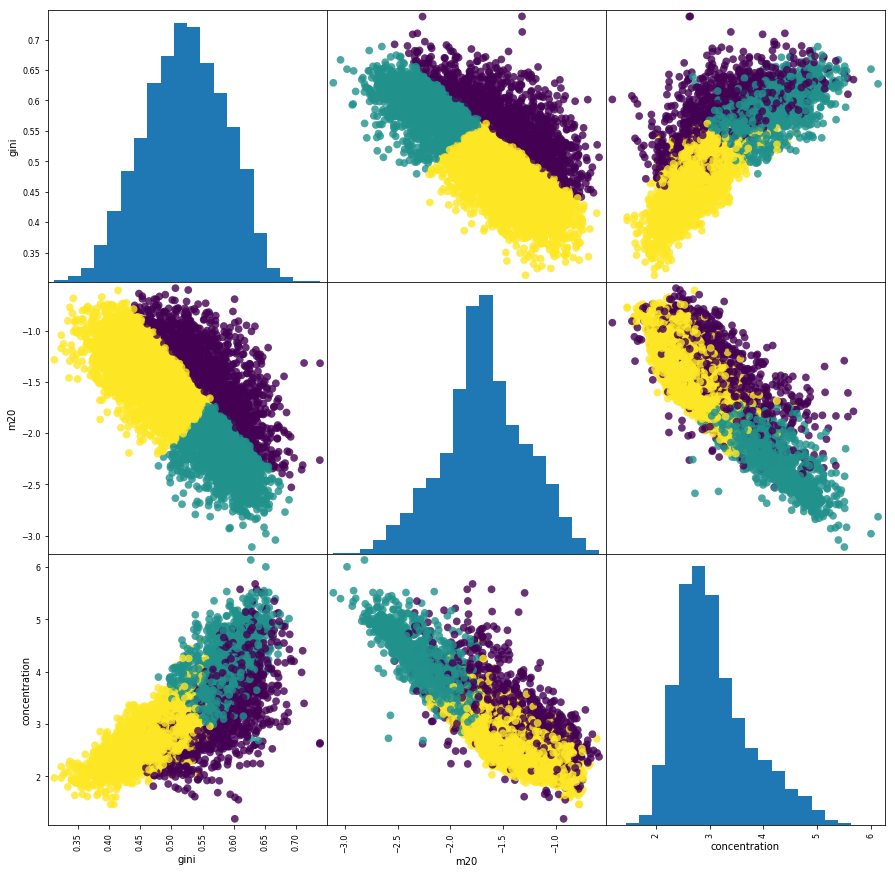

In [19]:
figure=pd.plotting.scatter_matrix(df[['gini','m20','concentration']],
                                  c=df['label'],figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

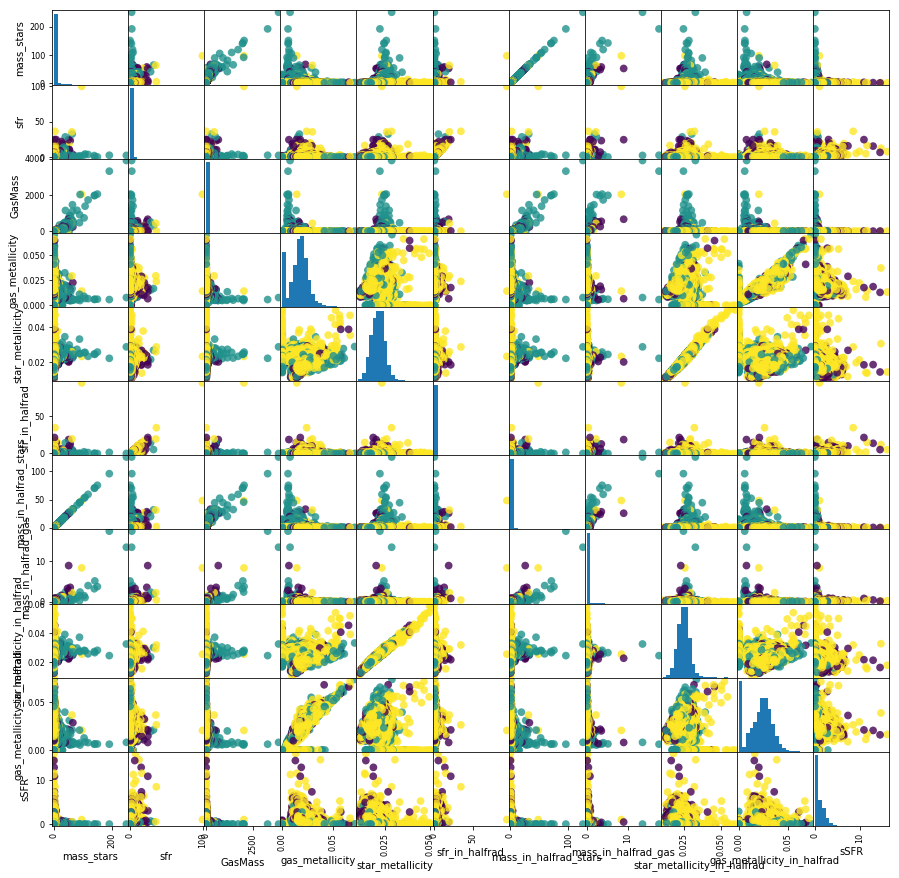

In [20]:
figure=pd.plotting.scatter_matrix(df.drop(["id",'flag','label','gini','m20','concentration','u_band',
       'b_band', 'v_band', 'k_band', 'g_band', 'r_band', 'i_band', 'z_band'],axis=1), c=df['label'],figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

#observe_pairs.drop(["id","pos_x","pos_y","pos_z","vel_x","vel_y","vel_z"]

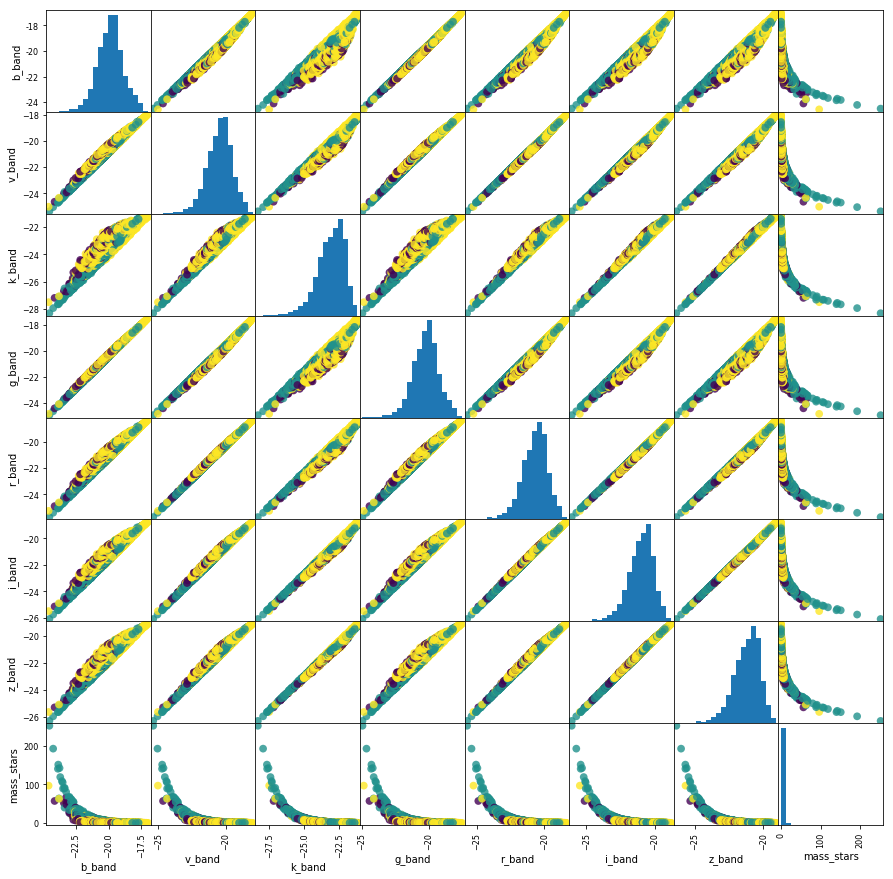

In [21]:
figure=pd.plotting.scatter_matrix(df[['b_band', 'v_band', 'k_band', 'g_band', 'r_band', 'i_band', 'z_band','mass_stars']], c=df['label'],figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)


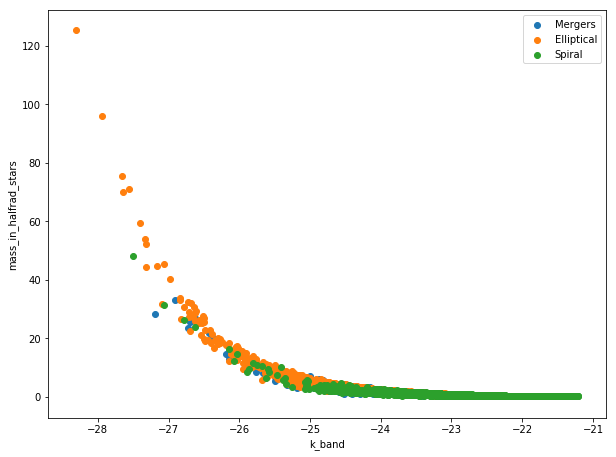

In [22]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["k_band"][df.label.values==0], df["mass_in_halfrad_stars"][df.label.values==0],label="Mergers")
axes.scatter(df["k_band"][df.label.values==1], df["mass_in_halfrad_stars"][df.label.values==1],label="Elliptical")
axes.scatter(df["k_band"][df.label.values==2], df["mass_in_halfrad_stars"][df.label.values==2],label="Spiral")

axes.set_xlabel("k_band")
axes.set_ylabel("mass_in_halfrad_stars")
#axes.invert_xaxis
axes.legend()
#axes.legend(['0','1','2'])
#fig.colorbar(scatter, ax=axes)

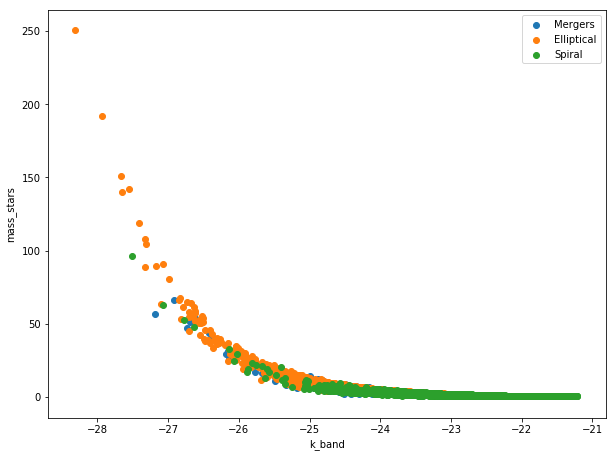

In [23]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["k_band"][df.label.values==0], df["mass_stars"][df.label.values==0],label="Mergers")
axes.scatter(df["k_band"][df.label.values==1], df["mass_stars"][df.label.values==1],label="Elliptical")
axes.scatter(df["k_band"][df.label.values==2], df["mass_stars"][df.label.values==2],label="Spiral")

axes.set_xlabel("k_band")
axes.set_ylabel("mass_stars")
#axes.invert_xaxis
axes.legend()
#axes.legend(['0','1','2'])
#fig.colorbar(scatter, ax=axes)

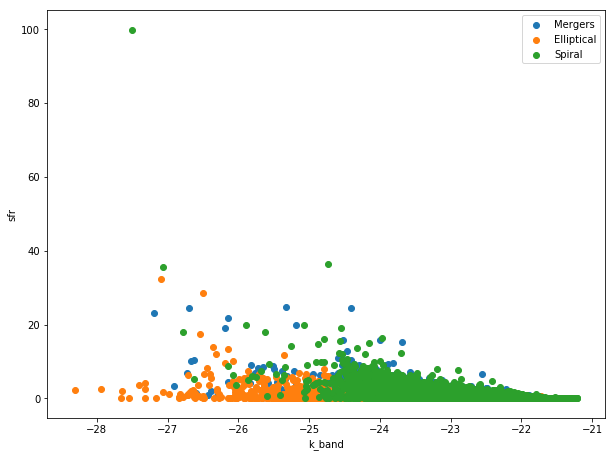

In [24]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["k_band"][df.label.values==0], df["sfr"][df.label.values==0],label="Mergers")
axes.scatter(df["k_band"][df.label.values==1], df["sfr"][df.label.values==1],label="Elliptical")
axes.scatter(df["k_band"][df.label.values==2], df["sfr"][df.label.values==2],label="Spiral")

axes.set_xlabel("k_band")
axes.set_ylabel("sfr")
#axes.invert_xaxis
axes.legend()

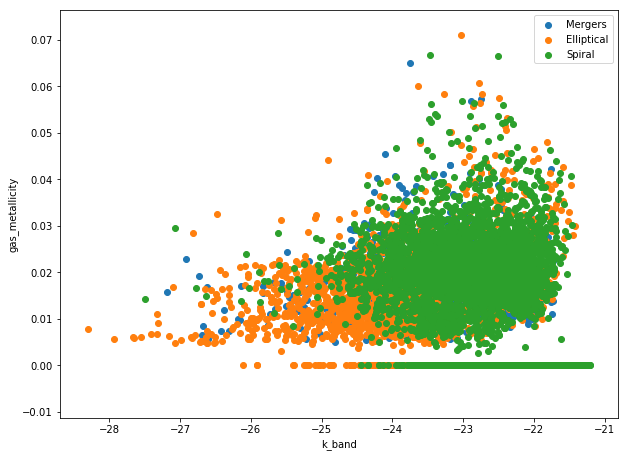

In [25]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["k_band"][df.label.values==0], df["gas_metallicity"][df.label.values==0],label="Mergers")
axes.scatter(df["k_band"][df.label.values==1], df["gas_metallicity"][df.label.values==1],label="Elliptical")
axes.scatter(df["k_band"][df.label.values==2], df["gas_metallicity"][df.label.values==2],label="Spiral")

axes.set_xlabel("k_band")
axes.set_ylabel("gas_metallicity")
#axes.invert_xaxis
axes.legend()

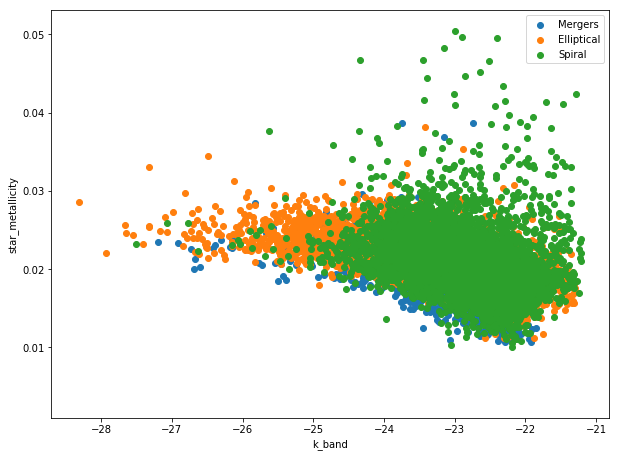

In [26]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["k_band"][df.label.values==0], df["star_metallicity"][df.label.values==0],label="Mergers")
axes.scatter(df["k_band"][df.label.values==1], df["star_metallicity"][df.label.values==1],label="Elliptical")
axes.scatter(df["k_band"][df.label.values==2], df["star_metallicity"][df.label.values==2],label="Spiral")

axes.set_xlabel("k_band")
axes.set_ylabel("star_metallicity")
#axes.invert_xaxis
axes.legend()

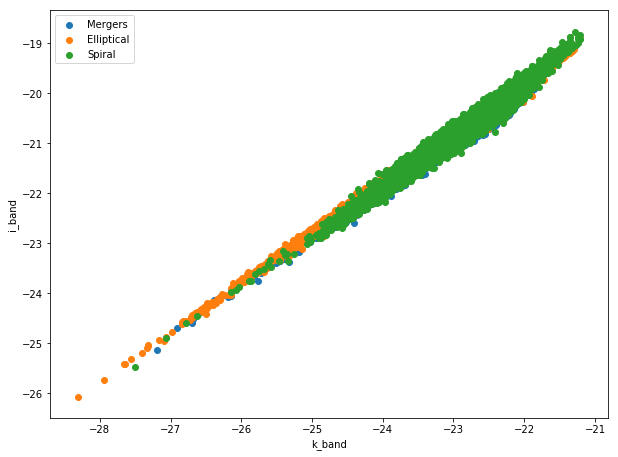

In [27]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["k_band"][df.label.values==0], df["i_band"][df.label.values==0],label="Mergers")
axes.scatter(df["k_band"][df.label.values==1], df["i_band"][df.label.values==1],label="Elliptical")
axes.scatter(df["k_band"][df.label.values==2], df["i_band"][df.label.values==2],label="Spiral")

axes.set_xlabel("k_band")
axes.set_ylabel("i_band")
#axes.invert_xaxis
axes.legend()

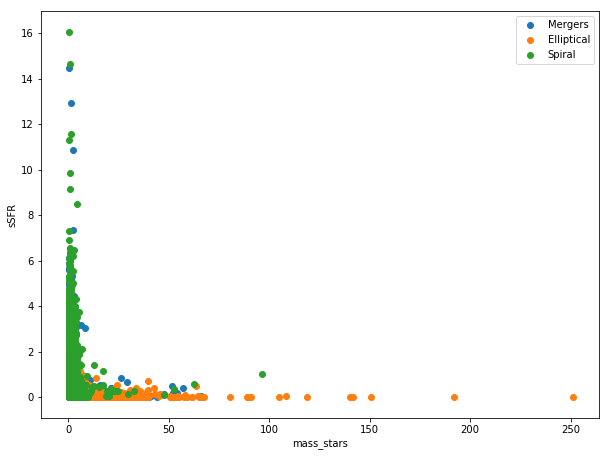

In [28]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(df["mass_stars"][df.label.values==0], df["sSFR"][df.label.values==0],label="Mergers")
axes.scatter(df["mass_stars"][df.label.values==1], df["sSFR"][df.label.values==1],label="Elliptical")
axes.scatter(df["mass_stars"][df.label.values==2], df["sSFR"][df.label.values==2],label="Spiral")

axes.set_xlabel("mass_stars")
axes.set_ylabel("sSFR")
#axes.invert_xaxis
axes.legend()

/Users/spencershortt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/spencershortt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/spencershortt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


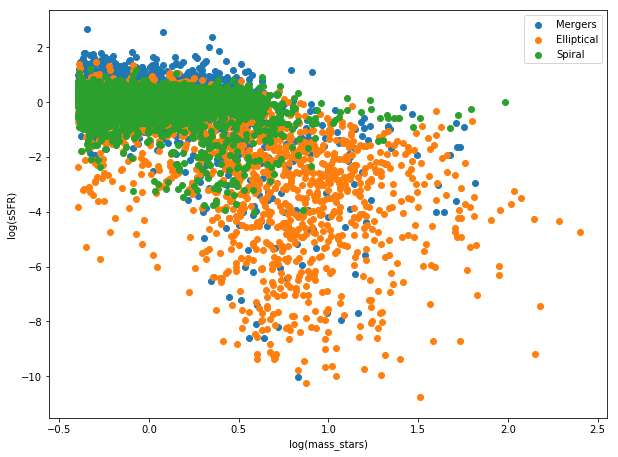

In [29]:
fig, axes=plt.subplots(1,1,figsize=(10,7.5))
#axes.scatter(df["mass_stars"], df["sSFR"],c=df["label"])
axes.scatter(np.log10(df["mass_stars"][df.label.values==0]), np.log(df["sSFR"][df.label.values==0]),label="Mergers")
axes.scatter(np.log10(df["mass_stars"][df.label.values==1]), np.log(df["sSFR"][df.label.values==1]),label="Elliptical")
axes.scatter(np.log10(df["mass_stars"][df.label.values==2]), np.log10(df["sSFR"][df.label.values==2]),label="Spiral")

axes.set_xlabel("log(mass_stars)")
axes.set_ylabel("log(sSFR)")
#axes.invert_xaxis
axes.legend()

In [30]:
#%matplotlib notebook


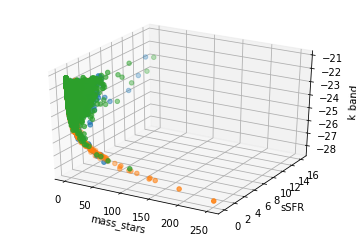

In [31]:
threedee2 = plt.figure().gca(projection='3d')
threedee2.scatter(df["mass_stars"][df.label.values==0], df["sSFR"][df.label.values==0],df["k_band"][df.label.values==0])
threedee2.scatter(df["mass_stars"][df.label.values==1], df["sSFR"][df.label.values==1],df["k_band"][df.label.values==1])
threedee2.scatter(df["mass_stars"][df.label.values==2], df["sSFR"][df.label.values==2],df["k_band"][df.label.values==2])
threedee2.set_xlabel("mass_stars")
threedee2.set_ylabel("sSFR")
threedee2.set_zlabel("k_band")
plt.show()